In [52]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import plotly.express as px
import scipy as sp
import warnings
warnings.filterwarnings('ignore')
from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import matplotlib.image as mpimg

In [53]:
from zipfile import ZipFile
data_path = '/content/Dog n Cat.zip'
with ZipFile(data_path, 'r') as zip:
  zip.extractall()
  print('The Data Set has been extracted')

The Data Set has been extracted


In [54]:
try:
    os.mkdir('/tmp/cats-vs-dogs')
    os.mkdir('/tmp/cats-vs-dogs/training')
    os.mkdir('/tmp/cats-vs-dogs/validation')
    os.mkdir('/tmp/cats-vs-dogs/test')
    os.mkdir('/tmp/cats-vs-dogs/training/cats')
    os.mkdir('/tmp/cats-vs-dogs/training/dogs')
    os.mkdir('/tmp/cats-vs-dogs/validation/cats')
    os.mkdir('/tmp/cats-vs-dogs/validation/dogs')
    os.mkdir('/tmp/cats-vs-dogs/test/cats')
    os.mkdir('/tmp/cats-vs-dogs/test/dogs')
except OSError:
    print('Error: directory could not be created')

Error: directory could not be created


In [55]:
cat_dir = '/content/PetImages/Cat'
dog_dir = '/content/PetImages/Dog'
training_dir = "/tmp/cats-vs-dogs/training"
validation_dir = "/tmp/cats-vs-dogs/validation"
training_cats = os.path.join(training_dir, "cats/")
validation_cats = os.path.join(validation_dir, "cats/")
training_dogs = os.path.join(training_dir, "dogs/")
validation_dogs = os.path.join(validation_dir, "dogs/")
include_test = True

In [56]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split=True, split_size=0.9):
    files = []
    for file in os.listdir(main_dir):
        if os.path.getsize(os.path.join(main_dir, file)):
            files.append(file)
        shuffled_files = random.sample(files, len(files))
        split = int(0.9*len(shuffled_files))
        train = shuffled_files[:split]
        split_valid_test = int(split+(len(shuffled_files)-split)/2)
    if include_test_split:
        validation = shuffled_files[split:split_valid_test]
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]
    for element in train:
        copyfile(os.path.join(main_dir,element), os.path.join(training_dir, element))
    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))
    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir, element), os.path.join(test_dir, element))
    print("Successfully Splitted")

In [57]:
split_data(cat_dir, '/tmp/cats-vs-dogs/training/cats', '/tmp/cats-vs-dogs/validation/cats', '/tmp/cats-vs-dogs/test/cats', include_test, 0.9)
split_data(dog_dir, '/tmp/cats-vs-dogs/training/dogs', '/tmp/cats-vs-dogs/validation/dogs', '/tmp/cats-vs-dogs/test/dogs', include_test, 0.9)

Successfully Splitted
Successfully Splitted


In [58]:
print(len(os.listdir('/tmp/cats-vs-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-vs-dogs/training/dogs')))
print(len(os.listdir('/tmp/cats-vs-dogs/validation/cats')))
print(len(os.listdir('/tmp/cats-vs-dogs/validation/dogs')))
print(len(os.listdir('/tmp/cats-vs-dogs/test/cats')))
print(len(os.listdir('/tmp/cats-vs-dogs/test/dogs')))

12383
12331
1220
1218
1226
1208


In [59]:
train_gen = ImageDataGenerator(rescale=1./255)
validation_gen =  ImageDataGenerator(rescale=1./255.)
if include_test:
    test_gen =  ImageDataGenerator(rescale=1./255.)

In [60]:
train_generator = train_gen.flow_from_directory('/tmp/cats-vs-dogs/training', target_size=(150,150), batch_size=64, class_mode='binary')
validation_generator = validation_gen.flow_from_directory('/tmp/cats-vs-dogs/validation', target_size=(150,150), batch_size=64, class_mode='binary')
if include_test:
    test_generator = test_gen.flow_from_directory('/tmp/cats-vs-dogs/validation', target_size=(150,150), batch_size=64, class_mode='binary')

Found 24714 images belonging to 2 classes.
Found 2438 images belonging to 2 classes.
Found 2438 images belonging to 2 classes.


In [61]:
class_names = ['Cat', 'Dog']
def plot_data(generator, n_images):
    images, labels = next(generator)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

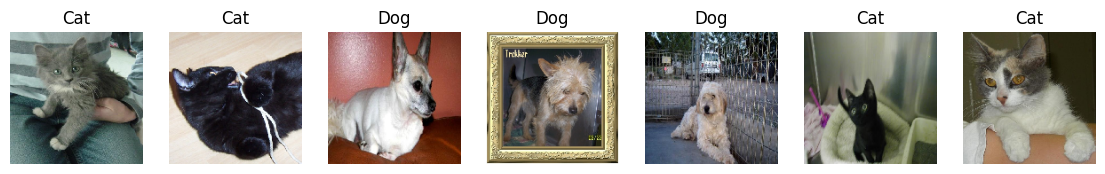

In [62]:
plot_data(train_generator,7)

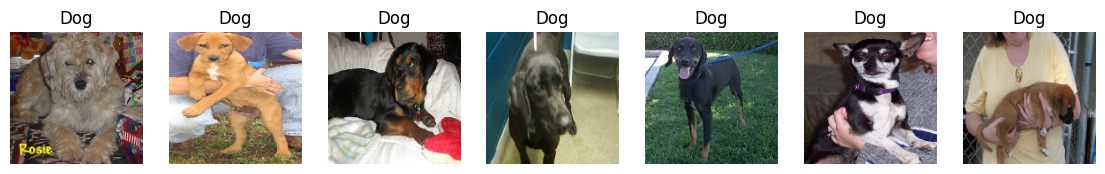

In [63]:
plot_data(validation_generator,7)

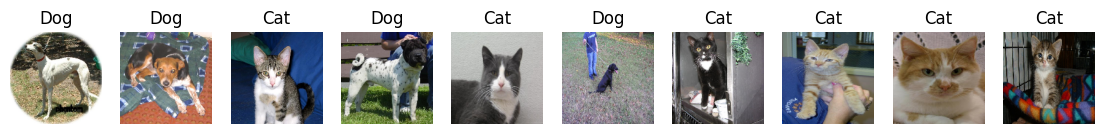

In [64]:
if include_test:
    plot_data(test_generator,10)

In [65]:
inputs = tf.keras.layers.Input(shape=(150,150,3))
x = tf.keras.layers.Conv2D(32,(3,3),activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x = tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x = tf.keras.layers.Conv2D(256,(3,3),activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model= Model(inputs=inputs, outputs=x)

In [66]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [67]:
r = model.fit(train_generator, epochs=30, validation_data=validation_generator)

Epoch 1/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 84s 211ms/step - accuracy: 0.5340 - loss: 0.6898 - val_accuracy: 0.6148 - val_loss: 0.6463
Epoch 2/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 66s 171ms/step - accuracy: 0.6189 - loss: 0.6483 - val_accuracy: 0.6624 - val_loss: 0.6149
Epoch 3/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 66s 170ms/step - accuracy: 0.6679 - loss: 0.6126 - val_accuracy: 0.7244 - val_loss: 0.5609
Epoch 4/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 66s 170ms/step - accuracy: 0.7003 - loss: 0.5804 - val_accuracy: 0.7137 - val_loss: 0.5600
Epoch 5/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 66s 170ms/step - accuracy: 0.7165 - loss: 0.5635 - val_accuracy: 0.7383 - val_loss: 0.5422
Epoch 6/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 66s 169ms/step - accuracy: 0.7291 - loss: 0.5422 - val_accuracy: 0.7055 - val_loss: 0.5868
Epoch 7/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 65s 168ms/step - accuracy: 0.7423 - loss: 0.5290 - val_accuracy: 0.7469 - val_loss: 0.5248
Epoch 8/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 66s 170ms/step - accuracy: 0.7527 - loss: 0

In [68]:
if include_test:
    model.evaluate(test_generator)

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9568 - loss: 0.1287


In [69]:
def plot_prediction(generator, n_images):
  images, labels = next(generator)
  preds = model.predict(images)
  predictions = np.argmax(preds, axis=1)
  labels = labels.astype('int32')
  plt.figure(figsize=(14, 15))
  for i in range(n_images):
    plt.subplot(4, 3, i+1)
    plt.imshow(images[i])
    if predictions[i] == labels[i]:
      title_obj = plt.title(class_names[labels[i]])
      plt.setp(title_obj, color='g')
    else:
      title_obj = plt.title(class_names[labels[i]])
      plt.setp(title_obj, color='r')
    plt.axis('off')
  plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step 


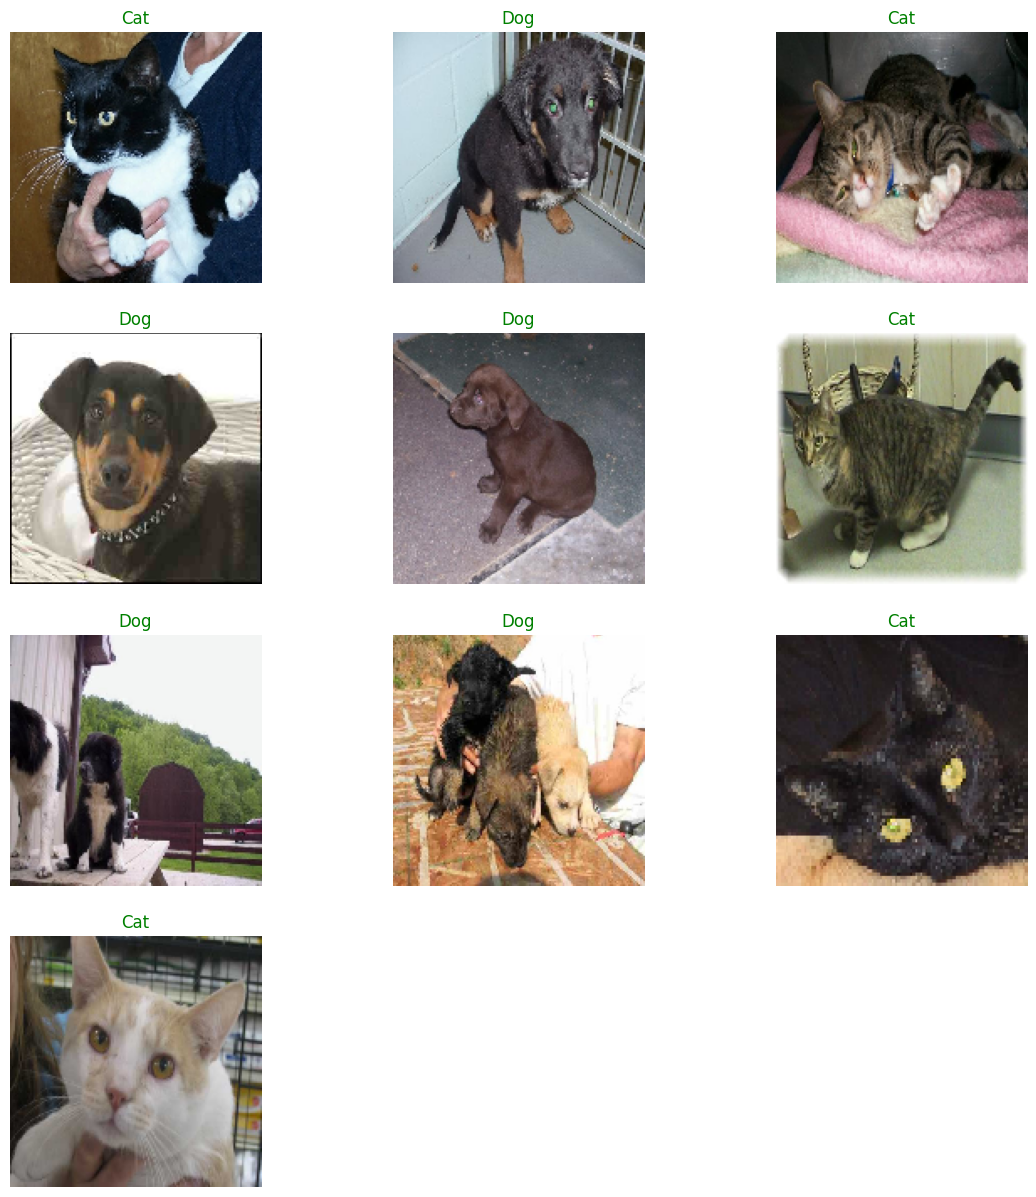

In [70]:
if include_test:
  plot_prediction(test_generator,10)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


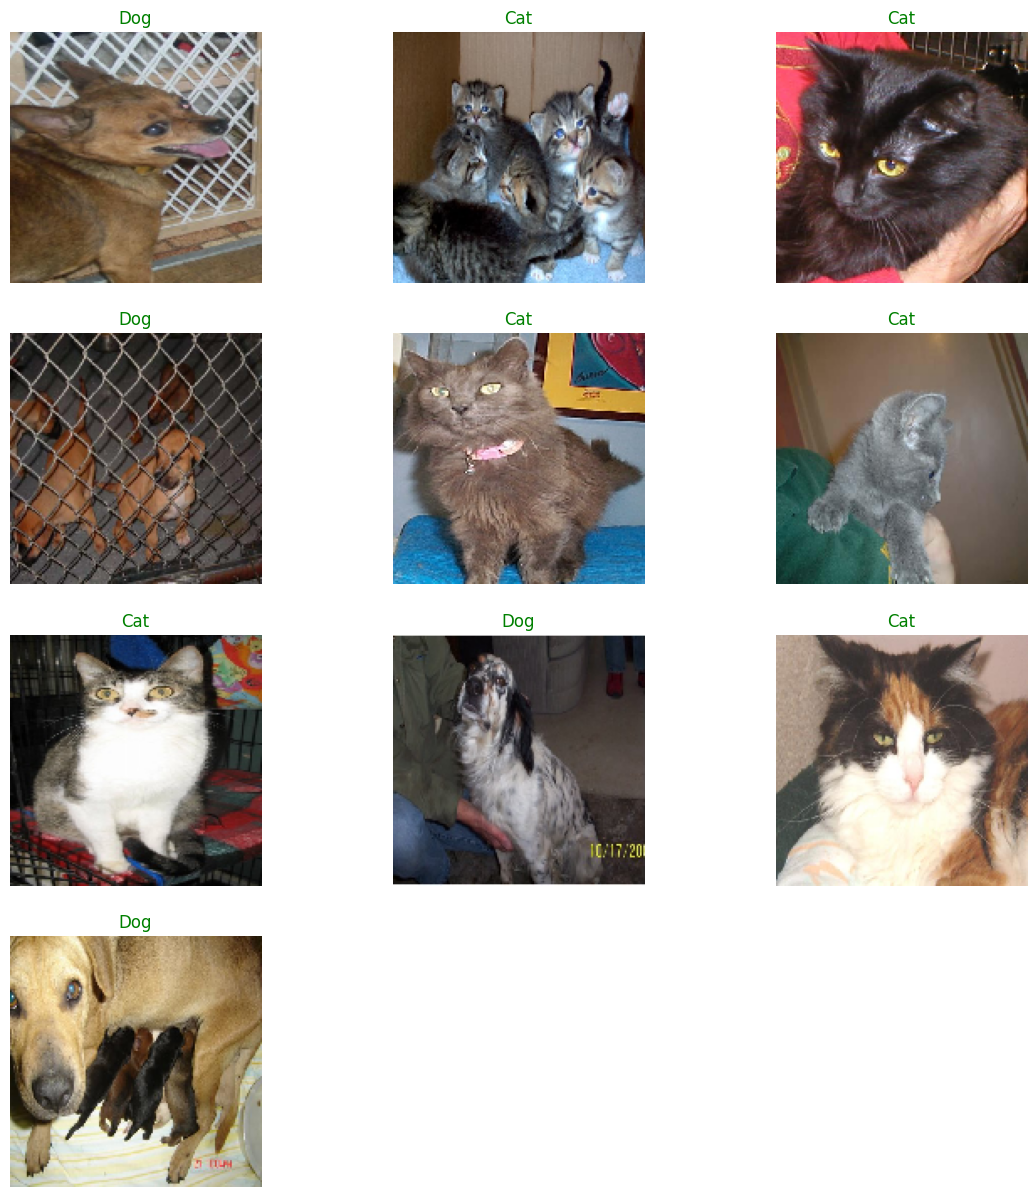

In [71]:
plot_prediction(validation_generator,10)

In [75]:
gp_weights = model.get_layer('dense_2').get_weights()[0]
activation_model = Model(model.inputs, outputs=(model.get_layer('conv2d_11').output, model.get_layer('dense_3').output))

In [76]:
images, _ = next(test_generator)
features, results = activation_model.predict(images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step 


In [77]:
def show_cam(image_index, features, results):
  features_for_img = features[image_index,:,:,:]
  prediction = np.argmax(results[image_index])
  class_activation_weights = gp_weights[:, prediction]
  class_activation_features = sp.ndimage.zoom(features_for_img,(150/30, 150/30, 1), order=2)
  cam_output = np.dot(class_activation_features, class_activation_weights)
  print('Predicted Class =' +str(class_names[prediction])+ ', Probability =' +str(results[image_index][prediction]))
  plt.imshow(images[image_index])
  if results[image_index][prediction]>0.95:
    cmap_str = 'Greens'
  else:
    cmap_str = 'Blues'
  plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)
  plt.show()

In [78]:
def show_maps(desired_class, num_maps):
  counter = 0
  for i in range(0,10000):
    if counter == num_maps:
      break
    if np.argmax(results[i]) == desired_class:
      counter += 1
      show_cam(i,features,results)

Predicted Class =Dog, Probability =0.9999677


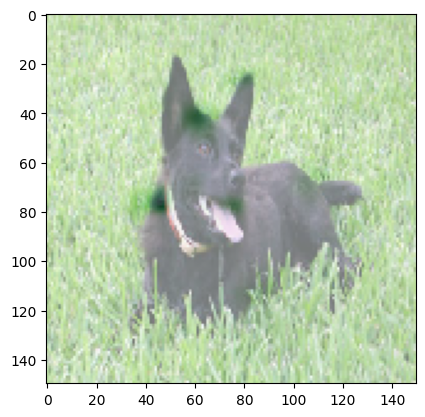

Predicted Class =Dog, Probability =0.99996734


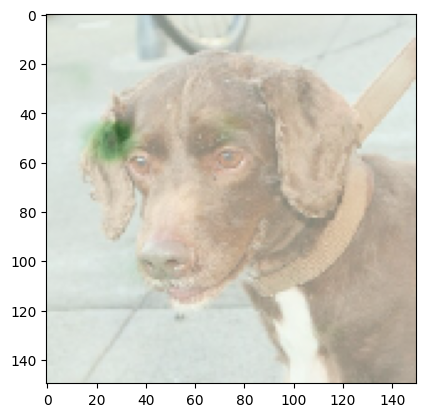

Predicted Class =Dog, Probability =0.9668123


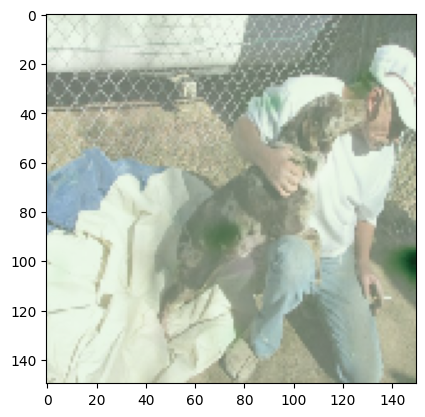

Predicted Class =Dog, Probability =0.9807659


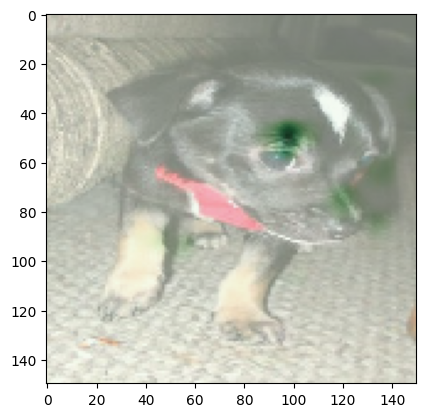

Predicted Class =Dog, Probability =0.70465577


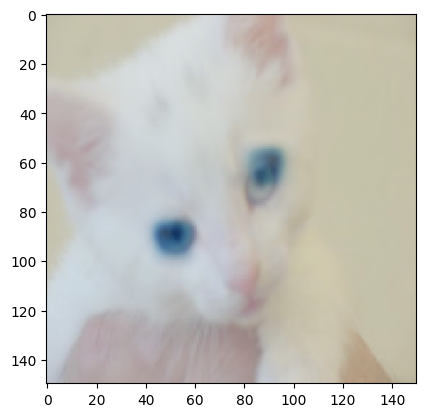

In [79]:
show_maps(desired_class=1, num_maps=5)

Predicted Class =Cat, Probability =0.99078363


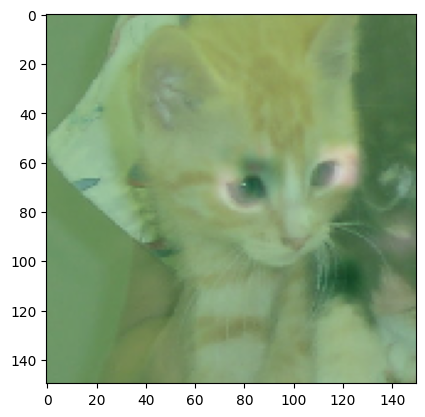

Predicted Class =Cat, Probability =0.92357516


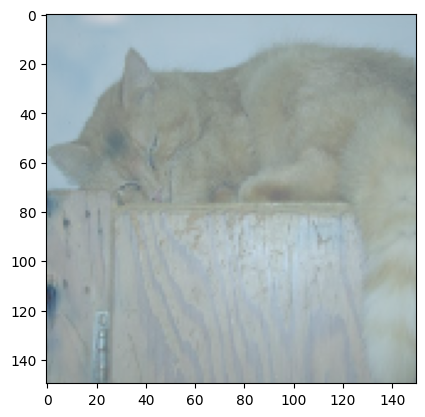

Predicted Class =Cat, Probability =0.9332741


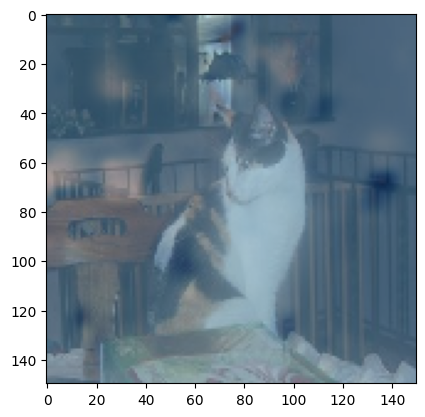

Predicted Class =Cat, Probability =0.8648184


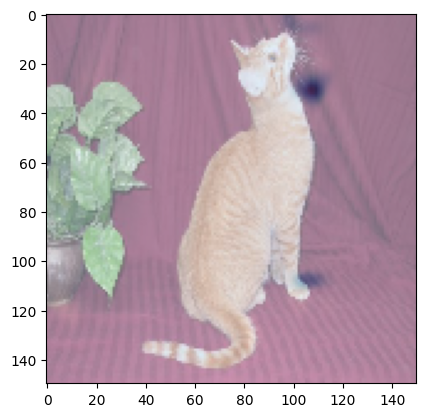

Predicted Class =Cat, Probability =0.9999987


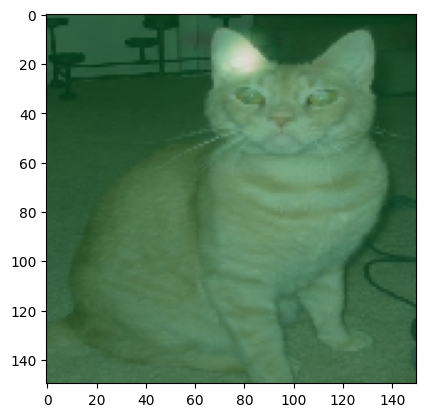

In [80]:
show_maps(desired_class=0,num_maps=5)

In [81]:
results = pd.DataFrame(r.history)
results.tail()

accuracy      loss  val_accuracy  val_loss
25  0.943392  0.143132      0.908121  0.210020
26  0.944364  0.135352      0.953651  0.121692
27  0.952254  0.119760      0.966776  0.089118
28  0.953225  0.116000      0.969237  0.079465
29  0.958040  0.108510      0.957752  0.112498

In [82]:
fig = px.line(results, y=[results['accuracy'], results['val_accuracy']], template="seaborn", color_discrete_sequence=['#fad25a','red'])
fig.update_layout(title_font_color="#fad25a", xaxis=dict(color="#fad25a", title='Epochs'), yaxis=dict(color="#fad25a"))
fig.show()

In [83]:
fig = px.line(results, y=[results['loss'], results['val_loss']], template="seaborn", color_discrete_sequence=['#fad25a', 'red'])
fig.update_layout(title_font_color="#fad25a", xaxis=dict(color="#fad25a", title='Epochs'), yaxis=dict(color="#fad25a"))
fig.show()

In [84]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
test_images, test_labels = next(test_generator)
test_predict = model.predict(test_images)
test_predict_binary = (test_predict > 0.5).astype(int)
roc_auc = roc_auc_score(test_labels, test_predict[:, 1])
precision = precision_score(test_labels, test_predict_binary[:, 1])
f1 = f1_score(test_labels, test_predict_binary[:, 1])
recall = recall_score(test_labels, test_predict_binary[:, 1])
accuracy = accuracy_score(test_labels, test_predict_binary[:, 1])
val_acc = r.history['val_accuracy'][-1]
val_loss = r.history['val_loss'][-1]
loss = r.history['loss'][-1]
print("ROC-AUC             :", roc_auc)
print("Precision           :", precision)
print("F1 score            :", f1)
print("Recall              :", recall)
print("Accuracy            :", accuracy)
print("Validation Accuracy :", val_acc)
print("Validation Loss     :", val_loss)
print("Loss                :", loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
ROC-AUC             : 1.0
Precision           : 1.0
F1 score            : 1.0
Recall              : 1.0
Accuracy            : 1.0
Validation Accuracy : 0.9577522277832031
Validation Loss     : 0.11249800771474838
Loss                : 0.10851025581359863


In [42]:
from zipfile import ZipFile
file_name = '/content/Sample Test Images(dog vs cat).zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [85]:
import cv2
import numpy as np
import os
def preprocess_image(image_path, target_size=(64,64)):
  img = cv2.imread(image_path)
  img = cv2.resize(img,target_size)
  img = img/ 255.0
  img = np.expand_dims(img, axis=0)
  return img

In [88]:
test_folder = "/content/Sample Test Images(dog vs cat)"
class_labels = ["Cat", "Dog"]
for filename in os.listdir(test_folder):
  image_path = os.path.join(test_folder, filename)
  try:
    img =preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]
    print(f"{filename} --> {class_labels[predicted_class]}")
  except:
    print(f"Skipped: {filename}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
test5.jpg --> Cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
test1.jpg --> Cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
test4.jpg --> Dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
test6.jpg --> Dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
test2.jpg --> Cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
test3.jpg --> Cat


In [89]:
model.save("Dog-vs-Cat_model_of_HR.h5")